In [1]:
from google.colab import drive
drive.mount("/content/drive")
%cd /content/drive/My Drive/Neural Network & Deep Learning/

Mounted at /content/drive
/content/drive/My Drive/Neural Network & Deep Learning


In [3]:
import torch
import torch.nn.functional as F
import glob
import random
from torchsummary import summary
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from prefetch_generator import BackgroundGenerator
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
from collections import defaultdict
from math import sqrt
from functools import reduce
import numpy as np
import math
from PIL import Image
cudnn.enabled = True
cudnn.benchmark = True

In [4]:
class DataLoaderX(DataLoader):
    def __iter__(self):
        return BackgroundGenerator(super().__iter__())

In [5]:
class SEBlock(nn.Module):
    def __init__(self, c_in):
        super().__init__()
        self.globalavgpooling = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(c_in, max(1, c_in // 16))
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(max(1, c_in // 16), c_in)
        self.sigmoid = nn.Sigmoid()
        self.c_in = c_in
    
    def forward(self, x):
        assert self.c_in == x.size(1)
        x = self.globalavgpooling(x)
        x = x.squeeze()
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = x.unsqueeze(-1).unsqueeze(-1)
        x = self.sigmoid(x)
        return x


class SEDense18(nn.Module):
    def __init__(self, num_class=751, needs_norm=True, is_reid=False):
        super().__init__()
        model = models.resnet18(pretrained=True)
        self.conv0 = model.conv1
        self.bn0 = model.bn1
        self.relu0 = model.relu
        self.pooling0 = model.maxpool
        self.basicBlock11 = model.layer1[0]
        self.seblock1 = SEBlock(64)

        self.basicBlock12 = model.layer1[1]
        self.seblock2 = SEBlock(64)

        self.basicBlock21 = model.layer2[0]
        self.seblock3 = SEBlock(128)
        self.ancillaryconv3 = nn.Conv2d(64, 128, 1, 2, 0)
        self.optionalNorm2dconv3 = nn.BatchNorm2d(128)

        self.basicBlock22 = model.layer2[1]
        self.seblock4 = SEBlock(128)

        self.basicBlock31 = model.layer3[0]
        self.seblock5 = SEBlock(256)
        self.ancillaryconv5 = nn.Conv2d(128, 256, 1, 2, 0)
        self.optionalNorm2dconv5 = nn.BatchNorm2d(256)

        self.basicBlock32 = model.layer3[1]
        self.seblock6 = SEBlock(256)

        self.basicBlock41 = model.layer4[0]
        self.seblock7 = SEBlock(512)
        self.ancillaryconv7 = nn.Conv2d(256, 512, 1, 2, 0)
        self.optionalNorm2dconv7 = nn.BatchNorm2d(512)

        self.basicBlock42 = model.layer4[1]
        self.seblock8 = SEBlock(512)

        self.avgpooling = model.avgpool
        # self.fc = nn.Linear(512, num_class)
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(256, num_class),
        )
        self.needs_norm = needs_norm
        self.is_reid = is_reid
    
    def forward(self, x):
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu0(x)
        x = self.pooling0(x)
        branch1 = x
        x = self.basicBlock11(x)
        scale1 = self.seblock1(x)
        x = scale1 * x + branch1

        branch2 = x
        x = self.basicBlock12(x)
        scale2 = self.seblock2(x)
        x = scale2 * x + branch2

        branch3 = x
        x = self.basicBlock21(x)
        scale3 = self.seblock3(x)
        if self.needs_norm:
            x = scale3 * x + self.optionalNorm2dconv3(self.ancillaryconv3(branch3))
        else:
            x = scale3 * x + self.ancillaryconv3(branch3)

        branch4 = x
        x = self.basicBlock22(x)
        scale4 = self.seblock4(x)
        x = scale4 * x + branch4

        branch5 = x
        x = self.basicBlock31(x)
        scale5 = self.seblock5(x)
        if self.needs_norm:
            x = scale5 * x + self.optionalNorm2dconv5(self.ancillaryconv5(branch5))
        else:
            x = scale5 * x + self.ancillaryconv5(branch5)

        branch6 = x
        x = self.basicBlock32(x)
        scale6 = self.seblock6(x)
        x = scale6 * x + branch6

        branch7 = x
        x = self.basicBlock41(x)
        scale7 = self.seblock7(x)
        if self.needs_norm:
            x = scale7 * x + self.optionalNorm2dconv7(self.ancillaryconv7(branch7))
        else:
            x = scale7 * x + self.ancillaryconv7(branch7)

        branch8 = x
        x = self.basicBlock42(x)
        scale8 = self.seblock8(x)
        x = scale8 * x + branch8

        x = self.avgpooling(x)
        x = x.view(x.size(0), -1)
        if self.is_reid:
            return x
        x = self.classifier(x)

        return x

my_model = SEDense18().cuda()
summary(my_model, input_size=(3, 128, 64))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 32]           9,408
       BatchNorm2d-2           [-1, 64, 64, 32]             128
              ReLU-3           [-1, 64, 64, 32]               0
         MaxPool2d-4           [-1, 64, 32, 16]               0
            Conv2d-5           [-1, 64, 32, 16]          36,864
       BatchNorm2d-6           [-1, 64, 32, 16]             128
              ReLU-7           [-1, 64, 32, 16]               0
            Conv2d-8           [-1, 64, 32, 16]          36,864
       BatchNorm2d-9           [-1, 64, 32, 16]             128
             ReLU-10           [-1, 64, 32, 16]               0
       BasicBlock-11           [-1, 64, 32, 16]               0
AdaptiveAvgPool2d-12             [-1, 64, 1, 1]               0
           Linear-13                    [-1, 4]             260
             ReLU-14                   

In [6]:
class MyDataset(Dataset):
    def __init__(self, image_path, pose_path, label_path, transform):
        super().__init__()
        self.image_path = image_path
        self.pose_path = pose_path
        self.label_path = label_path
        self.transform = transform
    
    def __len__(self):
        return len(self.image_path)
    
    def __getitem__(self, idx):
        image1 = self.image_path[idx]
        pose1 = self.pose_path[idx]
        random_index = random.choice([i for i in range(len(self.image_path)) if i != idx])
        image2 = self.image_path[random_index]
        pose2 = self.pose_path[random_index]
        relative_label = 0 if self.label_path[idx] == self.label_path[random_index] else 1
        absolute_label = self.label_path[idx]
        image1 = Image.open(image1).convert("RGB")
        image2 = Image.open(image2).convert("RGB")
        pose1 = transforms.ToTensor()(Image.open(pose1).convert("L"))
        pose2 = transforms.ToTensor()(Image.open(pose2).convert("L"))
        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)
        relative_label = torch.tensor(relative_label).int()
        absolute_label = torch.tensor(absolute_label).int()
        return image1, image2, pose1, pose2, relative_label, absolute_label


def relabel(label_set):
    label = 0
    latest_label = label_set[0]
    new_label_set = list()
    for cur_label in label_set:
        if cur_label != latest_label:
            label += 1
            latest_label = cur_label
        new_label_set.append(label)
    return new_label_set

In [7]:
# this happens within batch
# could we have anchor images? -> maybe we need to switch to triplet loss


class ContrastiveLossGoogle(nn.Module):
    def __init__(self, batch_size, temperature=0.5):
        super().__init__()
        self.batch_size = batch_size
        self.register_buffer("temperature", torch.tensor(temperature))
        self.register_buffer("negatives_mask", (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float())
            
    def forward(self, emb_i, emb_j):
        """
        emb_i and emb_j are batches of embeddings, where corresponding indices are pairs
        z_i, z_j as per SimCLR paper
        """
        z_i = F.normalize(emb_i, dim=1)
        z_j = F.normalize(emb_j, dim=1)

        representations = torch.cat([z_i, z_j], dim=0)
        similarity_matrix = F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)
        
        sim_ij = torch.diag(similarity_matrix, self.batch_size)
        sim_ji = torch.diag(similarity_matrix, -self.batch_size)
        positives = torch.cat([sim_ij, sim_ji], dim=0)
        
        nominator = torch.exp(positives / self.temperature)
        denominator = self.negatives_mask * torch.exp(similarity_matrix / self.temperature)
    
        loss_partial = -torch.log(nominator / torch.sum(denominator, dim=1))
        loss = torch.sum(loss_partial) / (2 * self.batch_size)
        return loss


In [8]:
class contrastiveLoss(nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=20.0):
        super(contrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive


class LabelSmoothing(nn.Module):
    """ NLL loss with label smoothing. """

    def __init__(self, smoothing=0.1):
        """ Constructor for the LabelSmoothing module.
        :param smoothing: label smoothing factor """
        super(LabelSmoothing, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing

    def forward(self, x, target):
        logprobs = torch.nn.functional.log_softmax(x, dim=-1)
        target = target.long()
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = self.confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()

I find it hard to do strict contrastive training since for the same person, there may be pose issues.

In [9]:
class PoseLoss(nn.Module):
    def __init__(self, margin=None):
        super().__init__()
    
    def forward(self, pose1, pose2):
        return torch.log(torch.clamp(torch.abs(torch.sum(pose1) - torch.sum(pose2)), 0.) + 1e-6)

class HybridLoss(nn.Module):
    def __init__(self, margin=20.0):
        super().__init__()
        self.contrastive = contrastiveLoss(margin)
        self.pose = PoseLoss()
    
    def forward(self, feature1, feature2, label, pose1, pose2):
        return 0.5 * self.contrastive(feature1, feature2, label) + 0.5 * self.pose(pose1, pose2)

In [10]:
def training_strategy(num_classes):
    # The followings are used for training the embedding network
    embedding = SEDense18(num_class=num_classes, is_reid=True).cuda()
    # loss_function_embedding = contrastiveLoss(margin=300)
    loss_function_embedding = HybridLoss(margin=200)
    optimizer_embedding = torch.optim.Adam(embedding.parameters(), lr=0.01, weight_decay=5e-4)
    lr_scheduler_embedding = torch.optim.lr_scheduler.StepLR(optimizer_embedding, step_size=2000, gamma=0.5)
    # The followings are used for training the classification network
    classifier = embedding.classifier
    loss_function_classifier = LabelSmoothing()
    optimizer_classifier = torch.optim.Adam(classifier.parameters(), lr=0.01, weight_decay=5e-4)
    lr_scheduler_classifier = torch.optim.lr_scheduler.StepLR(optimizer_classifier, step_size=2000, gamma=0.5)
    return embedding, loss_function_embedding, optimizer_embedding, lr_scheduler_embedding, \
        classifier, loss_function_classifier, optimizer_classifier, lr_scheduler_classifier


In [11]:
from torch.utils.data.dataset import TensorDataset


def train(image_path, pose_path, label_path, num_class, epochs=10, batch_size=32):
    transform = transforms.Compose([
        transforms.Resize((128, 64)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        transforms.RandomErasing(),                           
    ])
    losses_embed = list()
    losses_class = list()
    embed_model, loss_embed, optim_embed, lr_embed, class_model, loss_class, optim_class, lr_class = training_strategy(num_class)
    embed_model.train()
    for epoch in range(epochs):
        reid_dataset = MyDataset(image_path, pose_path, label_path, transform)
        dataloader = DataLoaderX(reid_dataset, batch_size, True, num_workers=4, pin_memory=True)
        iterator = tqdm(dataloader)
        for sample in iterator:
            optim_embed.zero_grad()
            image1, image2, pose1, pose2, labels, _ = sample
            image1 = image1.cuda()
            image2 = image2.cuda()
            labels = labels.cuda()
            feature1 = embed_model(image1)
            feature2 = embed_model(image2)
            loss = loss_embed(feature1, feature2, labels, pose1, pose2)
            losses_embed.append(loss.item() / batch_size)
            loss.backward()
            nn.utils.clip_grad_norm_(embed_model.parameters(), 10.)
            optim_embed.step()
            lr_embed.step()
            status = "epoch: {}, lr: {:.4f}, loss: {:.5f}".format(epoch, lr_embed.get_last_lr()[0], loss.item() / batch_size)
            iterator.set_description(status)
    # Once the training is completed, do the inference to obtain the embeddings
    embed_model = embed_model.eval()
    feature_set = list()
    label_set = list()
    with torch.no_grad():
        dataloader_inference = DataLoaderX(reid_dataset, batch_size, num_workers=4, pin_memory=True)
        print("Start Inferencing..................")
        for sample in tqdm(dataloader_inference):
            image1, _, _, _, _, labels = sample
            image1 = image1.cuda()
            feature1 = embed_model(image1)
            feature_set.append(feature1.detach().cpu())
            label_set.append(labels.detach().cpu())
    feature_set = torch.cat(feature_set, dim=0)
    label_set = torch.cat(label_set, dim=0)
    classDataset = TensorDataset(feature_set, label_set)

    class_model.train()
    for epoch in range(1):
        dataloader = DataLoaderX(classDataset, batch_size, True, num_workers=4, pin_memory=True)
        iterator = tqdm(dataloader)
        for sample in iterator:
            optim_class.zero_grad()
            embed, label = sample
            embed = embed.cuda()
            label = label.cuda()
            prediction = class_model(embed)
            loss = loss_class(prediction, label)
            losses_class.append(loss.item() / batch_size)
            loss.backward()
            nn.utils.clip_grad_norm_(class_model.parameters(), 10.)
            optim_class.step()
            lr_class.step()
            status = "epoch: {}, lr: {:.4f}, loss: {:.5f}".format(epoch, lr_embed.get_last_lr()[0], loss.item() / batch_size)
            iterator.set_description(status)
    class_model = class_model.eval()
    return embed_model, class_model, losses_embed, losses_class


def plot_losses(losses_embed, losses_class):
    plt.figure()
    plt.plot(losses_embed, linewidth=2, color="r", label="embedding loss")
    plt.plot(losses_class, linewidth=2, color="b", label="classifier loss")
    plt.xlabel("iterations")
    plt.ylabel("loss value")
    plt.title("loss functions")
    plt.legend()
    plt.grid()
    plt.show()

In [16]:
image_path = sorted(glob.glob("Market1501/bounding_box_train/*.jpg"))
pose_path = sorted(glob.glob("Market1501/bounding_box_train_pose/*.png"))
label_path = list(map(lambda x: int(x.split("/")[-1][:4]), image_path))
label_path = relabel(label_path)
print(max(label_path))
assert len(image_path) == len(pose_path)

750


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
epoch: 9, lr: 0.0025, loss: 1.99773: 100%|██████████| 405/405 [01:19<00:00,  5.10it/s]


Start Inferencing..................


epoch: 0, lr: 0.0025, loss: 0.20301: 100%|██████████| 405/405 [00:03<00:00, 120.78it/s]


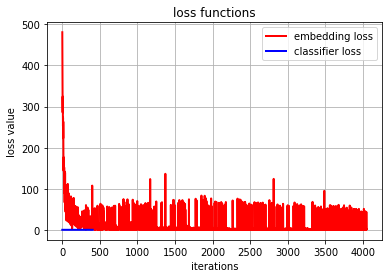

In [17]:
embed_model, class_model, losses_embed, losses_cls = train(image_path, pose_path, label_path, max(label_path)+1, 10)
plot_losses(losses_embed, losses_cls)

Overall test on image labelling

In [18]:
from collections import OrderedDict


overall_model = SEDense18().cuda()
overall_model.load_state_dict(embed_model.state_dict(), strict=False)
for key in class_model.state_dict():
    new_key = "classifier." + key
    class_model.state_dict()[new_key] = class_model.state_dict()[key].clone()
overall_model.load_state_dict(class_model.state_dict(), strict=False)
# traced_models = torch.jit.trace(overall_model, torch.randn((1,3,128,64)).to("cuda"))
# torch.jit.save(traced_models, "new_model_checkpoint_traced.pt")
torch.save(overall_model.state_dict(), "new_model_checkpoint.pt")

In [19]:
class TestDataset(Dataset):
    def __init__(self, image_path, label_path, transform):
        super().__init__()
        self.image_path = image_path
        self.label_path = label_path
        self.transform = transform

    def __len__(self):
        return len(self.image_path)
    
    def __getitem__(self, idx):
        image = self.image_path[idx]
        label = self.label_path[idx]
        image = Image.open(image).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label).int()


def test(image_path, label_path, batch_size=32):
    overall_model = SEDense18(num_class=max(label_path)+1).cuda()
    states = torch.load("new_model_checkpoint.pt", map_location=lambda storage, loc: storage)
    overall_model.load_state_dict(states)
    overall_model.eval()
    transform = transforms.Compose([
        transforms.Resize((128, 64)),  
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),                          
    ])
    test_dataset = TestDataset(image_path, label_path, transform)
    dataloader = DataLoaderX(test_dataset, batch_size, num_workers=4, pin_memory=True)
    acc = 0
    with torch.no_grad():
        iterator = tqdm(dataloader)
        for sample in iterator:
            image, label = sample
            image, label = image.cuda(), label.cuda()
            prediction = torch.argmax(overall_model(image), dim=1)
            acc += torch.count_nonzero(torch.eq(prediction, label))
    acc = acc / len(image_path)
    return acc

def test_dataset(path="Market1501/bounding_box_train"):
    image_path = sorted(glob.glob(path + "/*.jpg"))
    label_path = list(map(lambda x: int(x.split("/")[-1][:4]), image_path))
    label_path = relabel(label_path)
    return image_path, label_path



In [ ]:
image_path_test, label_path_test = test_dataset()
acc = test(image_path_test, label_path_test)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 405/405 [00:24<00:00, 16.74it/s]


In [ ]:
acc.item()

0.022649969905614853

Check the dissimilarity of the features. I want to know 
if my margin is convincing.

In [20]:
def dot_product(v1, v2):
    return sum(map(lambda x: x[0] * x[1], zip(v1, v2)))

def cosine_measure(v1, v2):
    prod = dot_product(v1, v2)
    len1 = math.sqrt(dot_product(v1, v1))
    len2 = math.sqrt(dot_product(v2, v2))
    return prod / (len1 * len2)


def feature_acquisition(embed_model, image_path, label_path, batch_size=32):
    transform = transforms.Compose([
        transforms.Resize((128, 64)),  
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),                                      
    ])
    dataset = TestDataset(image_path, label_path, transform)
    features = list()
    labels = list()
    torch.cuda.synchronize()
    with torch.no_grad():
        dataloader = DataLoaderX(dataset, batch_size, False, num_workers=4, pin_memory=True)
        iterator = tqdm(dataloader)
        for image, label in iterator:
            image, label = image.cuda(), label.cuda()
            feature = embed_model(image)
            features.append(feature.detach().cpu().numpy())
            labels.append(label.detach().cpu().numpy())
        features = np.concatenate(features, axis=0)
        labels = np.concatenate(labels, axis=0)
    return features, labels


def check_dissimilarity(features, labels):
    max_dis_same = 0.
    min_dis_diff = 1.
    dissimilarity_score = defaultdict(list)
    for idx, feature_x in enumerate(features):
        for idy, feature_y in enumerate(features):
            if idy <= idx:
                continue
            cosine_sim = cosine_measure(feature_x, feature_y)
            if labels[idx] == labels[idy]:
                dissimilarity_score[0].append(1 - cosine_sim)
                max_dis_same = max(max_dis_same, cosine_sim)
            else:
                dissimilarity_score[1].append(1 - cosine_sim)
                min_dis_diff = min(min_dis_diff, cosine_sim)
    return dissimilarity_score, max_dis_same, min_dis_diff


In [21]:
image_path, label_path = test_dataset("Market1501/bounding_box_test")

In [22]:
features, labels = feature_acquisition(embed_model, image_path, label_path)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 410/410 [02:27<00:00,  2.78it/s]


In [23]:
torch.cuda.empty_cache()

In [43]:
idx = random.randint(0, len(image_path))
idy = random.randint(0, len(image_path))
dis_sim = 1 - cosine_measure(features[idx], features[idy])
# dis_sim = np.sqrt(np.sum((features[idx] - features[idy]) ** 2))
print(image_path[idx], image_path[idy], dis_sim, labels[idx] == labels[idy])

dis_sim = 1 - cosine_measure(features[1], features[2])
# dis_sim = np.sqrt(np.sum((features[0] - features[1]) ** 2))
print(image_path[0], image_path[1], dis_sim, labels[0] == labels[1])

Market1501/bounding_box_test/0467_c3s1_129883_03.jpg Market1501/bounding_box_test/0561_c4s3_020704_02.jpg 0.6569712384917745 False
Market1501/bounding_box_test/0001_c1s1_001051_03.jpg Market1501/bounding_box_test/0001_c1s1_002301_02.jpg 0.5472896785567906 True


In [44]:
# Let me calculate the distance between different feature vectors
dis1 = np.sqrt(np.sum((features[idx] - features[idy]) ** 2))
dis2 = np.sqrt(np.sum((features[0] - features[1]) ** 2))
print("Different labels", dis1)
print("Same labels", dis2)

Different labels 320.73816
Same labels 266.7925


In [ ]:
# This will take humongous time to run
scores, max_dis_same, min_dis_diff = check_dissimilarity(features, labels)

In [ ]:
print("max_dis_same is", max_dis_same)
print("min_dis_diff is", min_dis_diff)

In [24]:
# the loss function should consider the pose
# Intuitively, we can set the loss function = 0.5 * contrastive loss + 0.5 * pose difference
# check the pose difference in manhattan distance


pose_image_path = sorted(glob.glob("Market1501/bounding_box_test_pose/*.jpg"))
pose_image_path = list(filter(lambda x: x.split("/")[-1][0] != "-" and x.split("/")[-1][:4] != "0000", pose_image_path))
pose1 = transforms.ToTensor()(Image.open(pose_image_path[0]).convert("L")).squeeze().numpy()
pose2 = transforms.ToTensor()(Image.open(pose_image_path[1]).convert("L")).squeeze().numpy()
pose3 = transforms.ToTensor()(Image.open(pose_image_path[2]).convert("L")).squeeze().numpy()
print("Difference between {} and {} image pose is {}".format(pose_image_path[0].split("/")[-1], pose_image_path[1].split("/")[-1], abs(pose1.sum() - pose2.sum())))
print("Difference between {} and {} image pose is {}".format(pose_image_path[1].split("/")[-1], pose_image_path[2].split("/")[-1], abs(pose2.sum() - pose3.sum())))

Difference between 0001_c1s1_001051_03_rendered.jpg and 0001_c1s1_002301_02_rendered.jpg image pose is 41.8156852722168
Difference between 0001_c1s1_002301_02_rendered.jpg and 0001_c1s1_002401_02_rendered.jpg image pose is 5.450984954833984
